In [39]:
import pandas as pd
import numpy as np
import datetime
import time

train = pd.read_csv("data/training_set_VU_DM_2014.csv")
test = pd.read_csv("data/kaggle_test.csv")

train = train.loc[train.random_bool == 0]
test = test.loc[test.random_bool == 0]

play = train.head(n=10000)

In [40]:
# Get date_time object from date_time string
def get_date_time(s):
    year = int(s[0:4])
    month = int(s[5:7])
    day = int(s[8:10])
    return datetime.datetime(year, month, day)

# Generate target month feature
def row_to_target_month(row):
    visit_date = get_date_time(row.date_time)
    target_date = visit_date + datetime.timedelta(days=int(row.srch_booking_window))
    return target_date.strftime('%m')

start = time.time()

# Get target month
for df in [train, play]:
    target_month = df.apply(row_to_target_month, axis=1)
    df["target_month"] = target_month
        
(time.time() - start)/60

C:\Users\Richard\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3.813822356859843

In [41]:
# Create dictionaries
pos_by_dest_prop_tmonth = train.groupby(["srch_destination_id", "prop_id", "target_month"]).position.median().to_dict()
pos_by_prop_tmonth = train.groupby(["prop_id", "target_month"]).position.median().to_dict()
pos_by_dest_prop = train.groupby(["srch_destination_id", "prop_id"]).position.median().to_dict()
pos_by_prop = train.groupby("prop_id").position.median().to_dict()
pos_by_dest = train.groupby("srch_destination_id").position.median().to_dict()

total_mean_pos = train.position.mean()

In [72]:

def series_add_est_pos(s):
    dest_id = s.srch_destination_id.iloc[0]
    prop_id = s.prop_id.iloc[0]
    tmonth = s.target_month.iloc[0]
    
    avg_pos = total_mean_pos
    #if ((dest_id, prop_id, tmonth) in pos_by_dest_prop_tmonth.keys()):
    #    avg_pos = pos_by_dest_prop_tmonth[(dest_id, prop_id, tmonth)]
    if ((prop_id, tmonth) in pos_by_prop_tmonth.keys()):
        avg_pos = pos_by_prop_tmonth[(prop_id, tmonth)]
    elif ((dest_id, prop_id) in pos_by_dest_prop.keys()):
        avg_pos = pos_by_dest_prop[(dest_id, prop_id)]
    elif (prop_id in pos_by_prop.keys()):
        avg_pos = pos_by_prop[prop_id]
    else:
        avg_pos = pos_by_dest[dest_id]
        
    return pd.Series(np.repeat(avg_pos, len(s)))

for df in [play]:
    df["est_pos"] = df.groupby(["prop_id", "srch_destination_id"]).apply(series_add_est_pos).reset_index(drop=True)

C:\Users\Richard\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [73]:
abs(play.position - play.est_pos).mean()

10.941232998225901

C:\Users\Richard\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


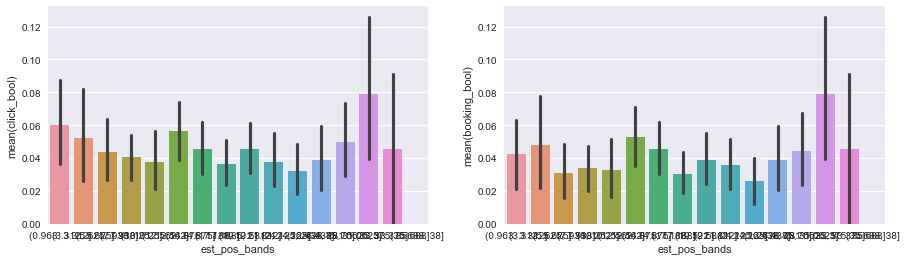

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

play["est_pos_bands"] = pd.cut(play.est_pos, bins=16)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="est_pos_bands", y="click_bool", data=play, ax=axis1)
sns.barplot(x="est_pos_bands", y="booking_bool", data=play, ax=axis2)

C:\Users\Richard\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


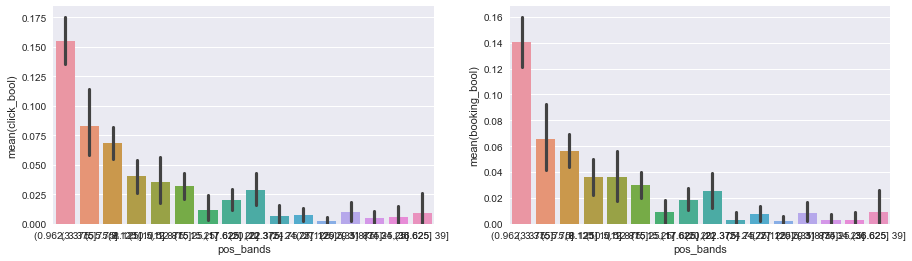

In [68]:
play["pos_bands"] = pd.cut(play.position, bins=16)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="pos_bands", y="click_bool", data=play, ax=axis1)
sns.barplot(x="pos_bands", y="booking_bool", data=play, ax=axis2)